In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

In [3]:
import os
import shutil

import numpy as np
import pandas as pd
import torch
from PIL import Image
from torchvision import transforms
from typing import List

from src.data_loader import get_data_loader
from src.model import DecoderRNN, DecoderRNNUpdated, EncoderCNN
from src.utils import Config, get_training_data, set_timezone, tag_date_time, sentence_similarity
import nltk
from src.utils import pick_random_test_image, copy_file_to_correct_folder, predict_image_caption, find_bleu_score, process_predicted_tokens

set_timezone()

Time-zone: ('IST', 'IST')


In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
transform_test = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

config = Config("config.yaml")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_data_loader = get_data_loader(
    transform=transform_test,
    caption_file=config.CAPTION_FILE,
    image_id_file=config.IMAGE_ID_FILE_TEST,
    image_folder=config.IMAGE_DATA_DIR,
    config=config,
    vocab_file=config.VOCAB_FILE,
    mode="test",
)

# Load model

In [4]:
# TODO #2: Specify the saved models to load.
print(f"DEV MODE: {config.DEV_MODE}")
if config.DEV_MODE:
    print("Loading dev model....")
    encoder_file = f"{config.MODEL_DIR}encoder-checkpoint-dev.pt"
    decoder_file = f"{config.MODEL_DIR}decoder-checkpoint-dev.pt"
else:
    encoder_file = f"{config.MODEL_DIR}encoder-checkpoint.pt"
    decoder_file = f"{config.MODEL_DIR}decoder-checkpoint.pt"

assert os.path.exists(
    encoder_file
), f"Encoder model: '{encoder_file}' doesn't not exist."
assert os.path.exists(
    decoder_file
), f"Decoder model: '{decoder_file}' doesn't not exist."

In [4]:
# TODO #3: Select appropriate values for the Python variables below.
embed_size = config.IMG_EMBED_SIZE
hidden_size = config.HIDDEN_SIZE
vocab_size = len(test_data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
# decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# DecoderRNNUpdated
decoder = DecoderRNNUpdated(
    embed_size, hidden_size, vocab_size, device=device
)

# Load the trained weights.
# map location helps in save and load accross devices (gpu/cpu)
encoder.load_state_dict(
    torch.load(encoder_file, map_location=device), strict=False
)
decoder.load_state_dict(
    torch.load(decoder_file, map_location=device), strict=False
)
encoder.eval()
decoder.eval()

print("Model loaded...")

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

df_test = get_training_data(config.IMAGE_ID_FILE_TEST, config.CAPTION_FILE)

Vocabulary successfully loaded from external file model/vocab.pkl...
DEV MODE: False


/home/sankarshan/Documents/code/image_captioning/src/utils.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)  # , Loader=yaml.FullLoader)


Model loaded...


# Prediction on Random test sample

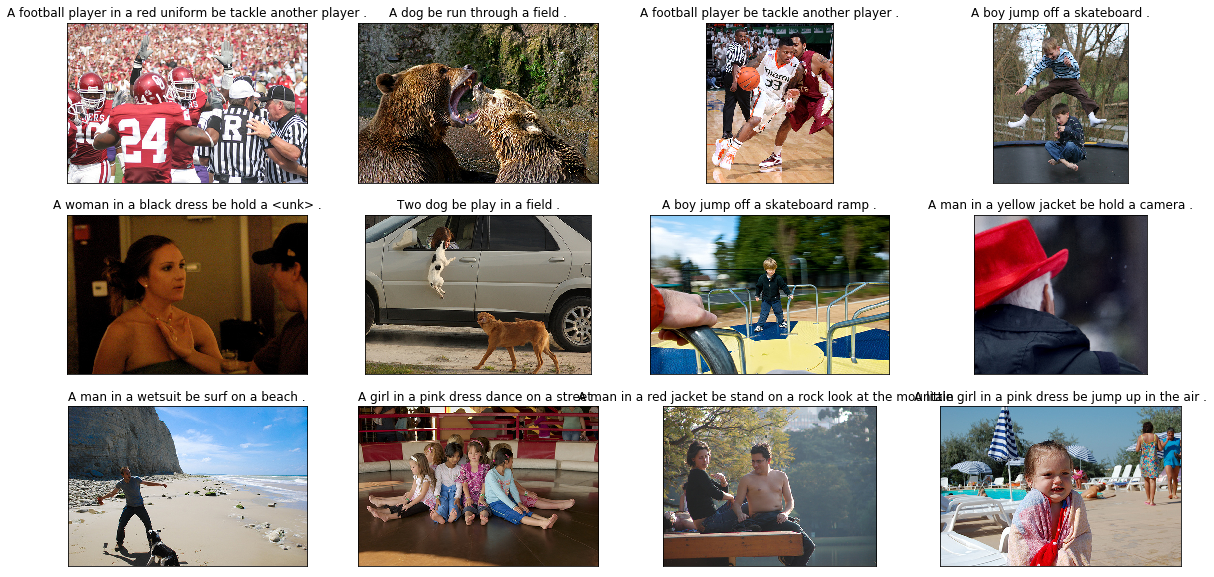

In [27]:
rows = 3
cols = 4
_, ax = plt.subplots(rows,cols,figsize=(20,10))
for row in range (rows):
    for col in range(cols):
        image_id, caption = pick_random_test_image(df_test)
        image_file = f"{config.IMAGE_DATA_DIR}{image_id}"

        pred_caption = predict_image_caption(
                    image_file,
                    transform_image=transform_test,
                    model_encoder=encoder,
                    model_decoder=decoder,
                    test_data_loader=test_data_loader,
                    device=device,
                )
        ax[row,col].imshow(Image.open(image_file))
        ax[row,col].set_title(pred_caption)
        ax[row,col].set_xticks([])
        ax[row,col].set_yticks([])

## Good Prediction on test data

In [24]:
image_file_list = ["461505235_590102a5bf.jpg", "3375070563_3c290a7991.jpg", 
                   "3064383768_f6838f57da.jpg", "3294209955_a1f1e2cc19.jpg", 
                   "3320356356_1497e53f80.jpg", "150387174_24825cf871.jpg", 
                   "2542662402_d781dd7f7c.jpg", "3316725440_9ccd9b5417.jpg"]

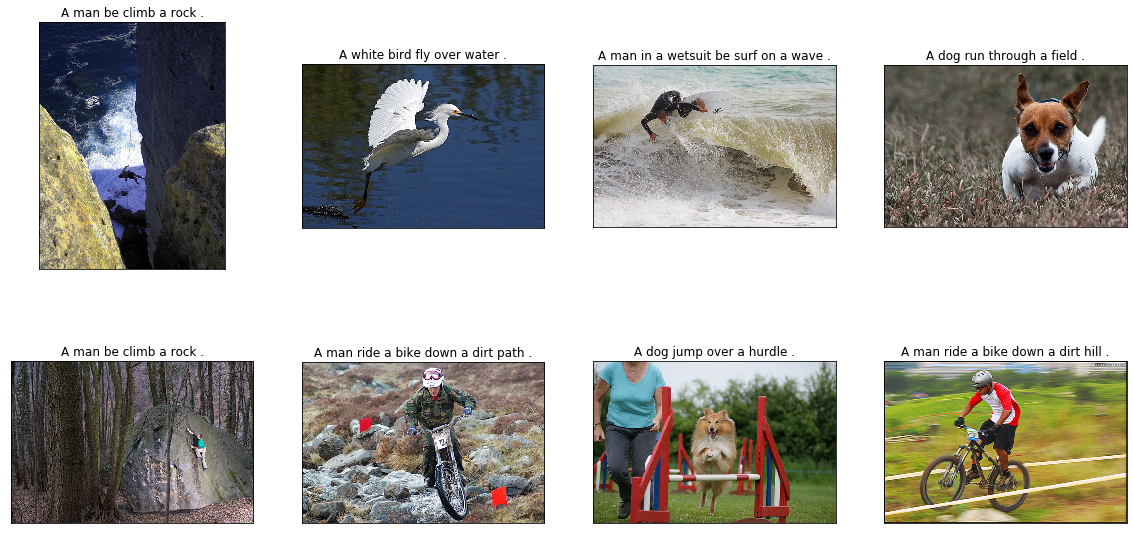

In [25]:
rows = 2
cols = 4
_, ax = plt.subplots(rows,cols,figsize=(20,10))
n = len(image_file_list)
i = 0
for row in range (rows):
    for col in range(cols):
        image_id = image_file_list[i]
        image_file = f"{config.IMAGE_DATA_DIR}{image_id}"

        pred_caption = predict_image_caption(
                    image_file,
                    transform_image=transform_test,
                    model_encoder=encoder,
                    model_decoder=decoder,
                    test_data_loader=test_data_loader,
                    device=device,
                )
        ax[row,col].imshow(Image.open(image_file))
        ax[row,col].set_title(pred_caption)
        ax[row,col].set_xticks([])
        ax[row,col].set_yticks([])
        i += 1